## Import Dependencies

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import tifffile

(288, 384, 3)


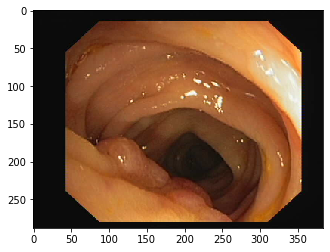

(288, 384)


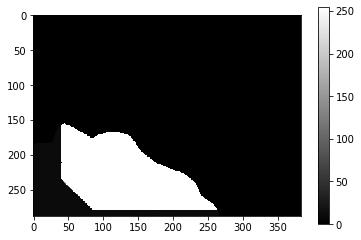

(288, 384)


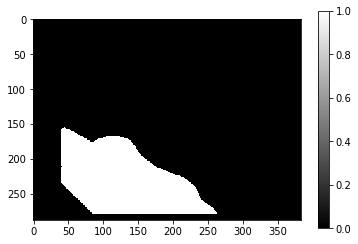

In [2]:
root_dir = "./train-data/CVC-ClinicDB"
input_dir = root_dir + "/Original/"
target_dir = root_dir + "/mask/"

im1 = tifffile.imread(input_dir + "1.tif")
print(im1.shape)
plt.imshow(im1)
plt.show()

g1 = tifffile.imread(root_dir + "/Ground-Truth/1.tif")
print(g1.shape)
plt.imshow(g1, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

m1 = np.load(target_dir + "1.npy")
print(m1.shape)
plt.imshow(m1, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# npy converter

In [ ]:
# Author: Jeffrey Ng

# Make sure to run this in the base directory ../polyp_data_to_label
import os
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
#import tifffile

import skimage.io as skio

FILE_NUM = '3'# Change to your file number
#FILE_NAME = '\\train-data\\CVC-ClinicDB' #+ 'images_to_label_' + FILE_NUM

FILE_NAME = '\\test-data\\ETIS-LaribPolypDB' #+ 'images_to_label_' + FILE_NUM

print(os.getcwd())

PATH = os.getcwd() + FILE_NAME + '\\Ground-Truth\\' # Change 'mask' to whatever directory you have your mask stored in
SAVE_PATH = os.getcwd() + FILE_NAME + '\\mask\\' # Likewise, 'output' to whatever output directory you wish

print(PATH)

#os.chdir(PATH)

for file in os.listdir(PATH):
    print(file)
    image = np.asarray(skio.imread(PATH+file))
    print(image.shape)
    bitmask_image = np.zeros((966, 1225))
    for i in range(966):
        for j in range(1225):
            if len(image.shape) == 3 and image[i, j, 0] >= 30 and image[i, j, 1] >= 30 and image[i, j, 2] >= 30:
                bitmask_image[i, j] = 1
    #print(image)
    #print(np.max(image))
    image = image / 255.0
    image[image < 1.0] = 0.0
    #print(image)
    #print(image.dtype)
    #print(np.any(image==1.0))
    #print( np.equal((image[image==1.0]), (image[image != 0.0])) )
    plt.imshow(image, cmap='gray')
    plt.show()
    # Debug
    # print(bitmask_image.shape)
    # print(type(bitmask_image))
    # print(file)
    #plt.imshow(bitmask_image, cmap='gray', vmin=0, vmax=1)
    #plt.show()

    # Saving image, check 2.1 and 2.2
    # https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/
    print(SAVE_PATH + file[:-4] + '.npy')
    np.save(SAVE_PATH + file[:-4] + '.npy', image)# Removes extension from file and appends .npy



## Define Dataset From Directory

In [3]:
def normalization(img, mean, sigma):
    centered_img = img - mean
    image = centered_img / sigma
    return image

In [4]:
class ColonImageDataset(Dataset):
    """Colon Polyps Project Dataset."""
    
    def __init__(self, input_dir, target_dir, transform=None, shuffle=False, split=False):
        """
        Args:
            input_dir  (string): Path to the csv file with annotations.
            target_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        
        self.input_list = sorted(os.listdir(input_dir))
        self.target_list = sorted(os.listdir(target_dir))
        
        if shuffle:
            # Randomize with a seed
            pass
        
        # Checks correctness of file directories
        assert len(self.input_list) == len(self.target_list)
        for file_idx in range(len(self.input_list)):
            assert self.input_list[file_idx][:-4] and self.target_list[file_idx][:-4]
            
        # Here we get the mean of the dataset
        total = 0.0
        for file_name in self.input_list:
            total += np.mean(plt.imread(self.input_dir + file_name))       
        self.mean = total/len(self)
        
        # Here we get the std of the dataset
        total = 0.0
        for file_name in self.input_list:
            total += np.square(np.mean(plt.imread(self.input_dir + file_name)) - self.mean)       
        total = total/len(self)
        self.std = np.sqrt(total)
        global global_mean 
        global global_std
        global_mean, global_std = self.mean, self.std
        print(self.mean, self.std)
        
        self.transform = lambda x: normalization(x, self.mean, self.std)
        
        
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        input_img = plt.imread(self.input_dir + self.input_list[idx])
        target_img = np.load(self.target_dir + self.target_list[idx])
        
        print(input_img.shape)
        if self.transform:
            input_img = self.transform(input_img)
        
        datum = (input_img, target_img)
        return datum        

In [44]:
class ColonTifDataset(Dataset):
    """Colon Polyps Project Dataset."""
    
    def __init__(self, input_dir, target_dir, transform=None, shuffle=False, split=False):
        """
        Args:
            input_dir  (string): Path to the csv file with annotations.
            target_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        
        self.input_list = sorted(os.listdir(input_dir))
        self.target_list = sorted(os.listdir(target_dir))
        
        if shuffle:
            # Randomize with a seed
            pass
        
        # Checks correctness of file directories
        assert len(self.input_list) == len(self.target_list)
        for file_idx in range(len(self.input_list)):
            assert self.input_list[file_idx][:-4] and self.target_list[file_idx][:-4]
            
        # Here we get the mean of the dataset
        total = 0.0
        for file_name in self.input_list:
            if (file_name[-4:] == ".tif"):
                total += np.mean(tifffile.imread(self.input_dir + file_name))
            elif (file_name[-4:] == ".jpg"):
                total += np.mean(plt.imread(self.input_dir + file_name))
        self.mean = total/len(self)
        
        # Here we get the std of the dataset
        total = 0.0
        for file_name in self.input_list:
            if (file_name[-4:] == ".tif"):
                total += np.square(np.mean(tifffile.imread(self.input_dir + file_name)) - self.mean)
            elif (file_name[-4:] == ".jpg"):
                total += np.square(np.mean(plt.imread(self.input_dir + file_name)) - self.mean)
        total = total/len(self)
        self.std = np.sqrt(total)
        global global_mean 
        global global_std
        global_mean, global_std = self.mean, self.std
        print(self.mean, self.std)
        
        self.transform = lambda x: normalization(x, self.mean, self.std)
        
        
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        input_img = np.array([])
        if ( (self.input_dir + self.input_list[idx])[-4:] == ".tif" ):
            input_img = tifffile.imread(self.input_dir + self.input_list[idx])
        elif ( (self.input_dir + self.input_list[idx])[-4:] == ".jpg" ):
            input_img = plt.imread(self.input_dir + self.input_list[idx])
            
        target_img = np.load(self.target_dir + self.target_list[idx])
        
        print(input_img.shape)
        if self.transform:
            input_img = self.transform(input_img)
        
        datum = (input_img, target_img)
        return datum        

## Helper Functions

In [45]:
# Helper function to show a batch
def show_colon_batch(datum_batched):
    batch_size = datum_batched[0].shape[0]
    f, ax = plt.subplots(batch_size, 2)
    
    if batch_size == 1:
        ax[0].imshow(datum_batched[0][0].numpy())
        ax[1].imshow(datum_batched[1][0].numpy()) 
    else:
        for i in range(batch_size):
            ax[i, 0].imshow(datum_batched[0][i].numpy())
            ax[i, 1].imshow(datum_batched[1][i].numpy())

    plt.show()
    
# Changes NHWC to NCHW
def change_input_dimension(X):
    altered_X = torch.zeros((X.shape[0], X.shape[3], X.shape[1], X.shape[2]), dtype=X.dtype)
    for i in range(X.shape[0]):
        altered_X[i,0,:,:] = X[i,:,:,0]
        altered_X[i,1,:,:] = X[i,:,:,1]
        altered_X[i,2,:,:] = X[i,:,:,2]
    return altered_X
    
# Changes NCHW to NHWC
def change_output_dimension(Y):
    return Y

## Create Dataloader

In [57]:
#root_dir = "/home/jeffrey/colon-polyps-project-data/polyp_data_to_label/all_images/"
root_dir = "./public-and-siwei3"
input_dir = root_dir + "/original/"
target_dir = root_dir + "/mask/"

colon_dataset = ColonTifDataset(input_dir, target_dir)

71.1296770913213 13.212438032146087


In [58]:
dataloader = DataLoader(colon_dataset, batch_size=1, shuffle=False)
# Grab the first batch
first_batch = None
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 0:
        first_batch = sample_batched
        break

(288, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


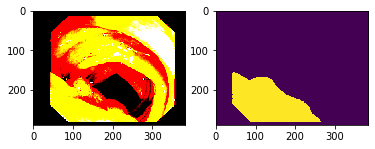

In [59]:
show_colon_batch(first_batch)

In [60]:
np.mean(first_batch[0][0].numpy())

0.14759642868336748

In [61]:
# EDA; Just code to figure out what the numpy  array contains
# Should be in {0, 1}
first_batch[1][0].shape
s = set()
for i in range(first_batch[1][0].shape[0]):
    for j in range(first_batch[1][0].shape[1]):
        s.add(first_batch[1][0][i,j].item())
    
s

{0.0, 1.0}

## Define U-Net Model

In [62]:
# Code is from https://github.com/jvanvugt/pytorch-unet/blob/master/unet.py
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

## Training Loop

In [63]:
from torchvision import models

def load_vgg_weight(model):
    vgg_model = models.vgg16(pretrained=True).to(device)
    model.down_path[0].block[0].weight = vgg_model.features[0].weight
    model.down_path[0].block[0].bias = vgg_model.features[0].bias
    model.down_path[0].block[2].weight = vgg_model.features[2].weight
    model.down_path[0].block[2].bias = vgg_model.features[2].bias

    model.down_path[1].block[0].weight = vgg_model.features[5].weight
    model.down_path[1].block[0].bias = vgg_model.features[5].bias
    model.down_path[1].block[2].weight = vgg_model.features[7].weight
    model.down_path[1].block[2].bias = vgg_model.features[7].bias
    
    model.down_path[2].block[0].weight = vgg_model.features[10].weight 
    model.down_path[2].block[0].bias = vgg_model.features[10].bias
    model.down_path[2].block[2].weight = vgg_model.features[12].weight
    model.down_path[2].block[2].bias = vgg_model.features[12].bias
    
    model.down_path[3].block[0].weight = vgg_model.features[17].weight
    model.down_path[3].block[0].bias = vgg_model.features[17].bias
    model.down_path[3].block[2].weight = vgg_model.features[19].weight
    model.down_path[3].block[2].bias = vgg_model.features[19].bias
    
    return model

In [64]:
print( torch.cuda.is_available() )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, n_classes=2, padding=True, up_mode='upconv')

# learning rate 1^e-4
#lr = 0.0001
#print(model.parameters())

True


In [65]:
model = load_vgg_weight(model).to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

expon_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)


In [66]:
loss_l = []
epochs = 25
print("Epochs: ", epochs)
for _ in range(epochs):
    #X, y = dataloader
    print("Epoch #: ", _)
    for i_batch, sample_batched in enumerate(dataloader):
        batch_shape = sample_batched[0].shape
        # Changing dimension
        X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
        #X = sample_batched[0].view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2]).to(dtype=torch.float)
        y = sample_batched[1].to(dtype=torch.int64)
        X = X.to(device)
        y = y.to(device)
        
        prediction =  model(X)
        loss = F.cross_entropy(prediction, y)
        
        X = X.cpu()
        y = y.cpu()
        
        if i_batch == 299 or len(loss_l) == 0:
            loss_l.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    expon_scheduler.step()


Epochs:  25
Epoch #:  0
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640,

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
Epoch #:  8
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 38

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
Epoch #:  13
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 6

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 384, 3)
(288, 

In [67]:
# Printing out loss per epoch
loss_l

[0.7131268382072449,
 0.10655078291893005,
 0.15327291190624237,
 0.12688325345516205,
 0.16610445082187653,
 0.2931990623474121,
 0.16730815172195435,
 0.13392303884029388,
 0.11309824883937836,
 0.15533548593521118,
 0.19233383238315582,
 0.0740387886762619,
 0.07371307164430618,
 0.07079625129699707,
 0.09985454380512238,
 0.07056009024381638,
 0.06909008324146271,
 0.06236381456255913,
 0.06274759769439697,
 0.06327033787965775,
 0.06512384861707687,
 0.06519488245248795,
 0.06558490544557571,
 0.0637042298913002,
 0.06314709782600403,
 0.0580533929169178]

## Inference

In [68]:
# Grab the first batch
first_batch = None
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 0:
        first_batch = sample_batched
        break

(288, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


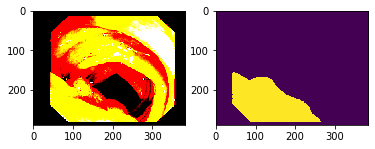

In [69]:
show_colon_batch(first_batch)

In [70]:
# Getting predicted mask; Inference
model = model.cpu()
X_inf = change_input_dimension(first_batch[0]).to(dtype=torch.float)
y_inf = first_batch[1].to(dtype=torch.int64)
y_ = model(X_inf)


In [71]:
# Moving image to cpu
y_ = y_.cpu()

y_ = y_.detach().numpy()



In [72]:
y_.shape

(1, 2, 288, 384)

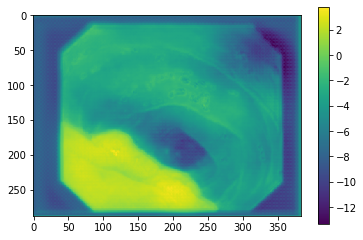

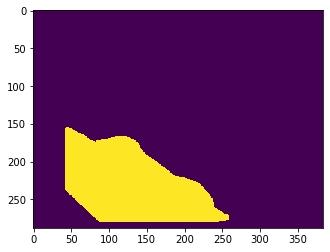

In [73]:
plt.imshow(y_[0][1])
plt.colorbar()
plt.show()

plt.imshow(y_[0][1] > 0)
plt.show()

In [74]:
torch.save(model.state_dict(), "colon-unet-public-private3-dataset-25epochs.pt")

In [59]:
model2 = UNet(in_channels=3, n_classes=2, padding=True, up_mode='upconv')
model2.load_state_dict( torch.load("colon-unet-public-dataset.pt") )

<All keys matched successfully>

In [60]:
model.parameters()

<generator object Module.parameters at 0x0000025875071E48>

In [61]:
# Checking for same weights/params (?) [Taking from online so not entirely sure if correct]
for p1, p2 in zip(model.parameters(), model2.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print(False)
print(True)

True


In [25]:
#print(loss_l)
np.save("colon-unet-loss-l-public-data-25epochs.npy", loss_l)

[0.83653885 0.1760747  0.1615596  0.16484644 0.15692347 0.15410735
 0.15631109 0.15208738 0.15080445 0.14570132 0.15319014 0.14744391
 0.14689386 0.14518586 0.14436613 0.13817832 0.13859279 0.13454778
 0.1545821  0.13541204 0.13530472 0.13212134 0.29545203 0.14912881
 0.13756293 0.1407695  0.14008035 0.14026493 0.139274   0.13789138
 0.13947296 0.14194316 0.14086752 0.13541389 0.15781246 0.14045998
 0.14047489 0.15506929 0.15206592 0.15995131 0.16346988 0.14394206
 0.14470924 0.13860519 0.11950947 0.13850139 0.14096086 0.14639515
 0.15377618 0.14898355 0.14821869 0.14026649 0.14578988 0.13999714
 0.13991168 0.13600279 0.14082061 0.14983581 0.13793968 0.13986166
 0.12619032 0.12520969 0.12511824 0.12297615 0.12417078 0.121816
 0.12084875 0.12104139 0.12152625 0.12298232 0.13028237 0.12364832
 0.12439629 0.12426997 0.12284118 0.12332808 0.12556885 0.12398734
 0.12300873 0.12295257 0.12038046 0.12102998 0.12407818 0.12367236
 0.12323719 0.1219509  0.12239751 0.12319959 0.12260094 0.125761

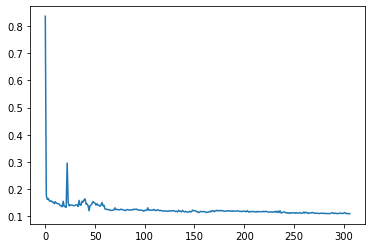

In [67]:
loaded_loss = np.load("colon-unet-loss-l-public-data.npy")
print(loaded_loss)
print(loaded_loss.shape)
plt.plot(loaded_loss)
plt.show()

# Test Run with IoU

In [75]:
model = UNet(in_channels=3, n_classes=2, padding=True, up_mode='upconv')
model.load_state_dict( torch.load("colon-unet-public-private3-dataset-25epochs.pt") )

<All keys matched successfully>

In [76]:
def iou(prediction, target):
    assert prediction.shape == target.shape # Number of targets and predicted outputs do not match

    if type(prediction) is not np.ndarray:
        prediction = (prediction >= 0).to(dtype=torch.int64).detach().numpy()
    else:
        prediction = (prediction >= 0).astype('int64')
    if type(target) is not np.ndarray:
        target = target.to(dtype=torch.int64).numpy()
    #print(type(prediction))
    #prediction = (prediction >= 0).to(dtype=torch.int64).numpy()
    #target = target.numpy()
    #plt.imshow(prediction[0])
    
    list_of_intersection = []
    for intersection in (prediction*target):
        list_of_intersection.append(intersection.sum())
        
    #plt.imshow((prediction*target).squeeze())
    
    list_of_union = []
    for union in (prediction + target):
        list_of_union.append(union.sum())
        
    print(list_of_intersection, list_of_union)
    
    return np.array(list_of_intersection) / (np.array(list_of_union) - np.array(list_of_intersection))
    #return intersection / ( union - intersection)

In [77]:
dataloader = DataLoader(colon_dataset, batch_size=1, shuffle=False)

iou_l = []
for i_batch, sample_batched in enumerate(dataloader):
    #print(i_batch)
    #print(sample_batched)
    batch_shape = sample_batched[0].shape
    # Changing dimension
    X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
    #X = sample_batched[0].view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2]).to(dtype=torch.float)
    y = sample_batched[1].to(dtype=torch.int64)
    #X = X.to(device)
    #y = y.to(device)
        
    y_pred =  model(X)
    y_pred = y_pred.cpu()
    y_pred = y_pred.detach().numpy()
    y_pred = y_pred[0][1]
    #plt.imshow(y_pred)
    #plt.colorbar()
    #plt.show()
    #print(np.abs(y_pred - y.detach().numpy()))    
    y_pred = torch.Tensor([y_pred])    
    #print(y_pred[0][0])
    #print(y_pred[0].shape)
    print(y_pred.shape)
    print(y.shape)
    i = iou(y_pred, y)
    print(i)
    iou_l.append(i)

(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[16603] [33744]
[0.96861327]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[13285] [34033]
[0.64030268]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7101] [14777]
[0.92509119]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7725] [16440]
[0.88640275]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7695] [16560]
[0.8680203]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[9399] [20460]
[0.84974234]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[12756] [27378]
[0.87238408]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[15501] [32218]
[0.92725968]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[11622] [26361]
[0.78852025]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[20206] [42104]
[0.92273267]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 

torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[10455] [70574]
[0.17390509]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[2718] [112647]
[0.02472505]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[10038] [20779]
[0.93454986]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4620] [10055]
[0.850046]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7090] [14988]
[0.89769562]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[6186] [13309]
[0.8684543]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[507] [16348]
[0.03200556]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5136] [18628]
[0.38067003]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7628] [19374]
[0.64941257]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[12645] [30658]
[0.70199301]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[15097] 

torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[10248] [36846]
[0.38529213]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[8173] [95931]
[0.09313111]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[8211] [50114]
[0.19595256]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[4279] [46166]
[0.1021558]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[14493] [36436]
[0.66048398]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[6768] [14996]
[0.82255712]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[29396] [119729]
[0.32541817]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[34066] [93060]
[0.57744855]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[7243] [115395]
[0.06697056]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[3598] [23363]
[0.18203896]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[86

torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[0] [22761]
[0.]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[1267] [20617]
[0.06547804]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[4] [21879]
[0.00018286]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[1453] [34377]
[0.04413194]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[5248] [13434]
[0.64109455]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[0] [20240]
[0.]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[2] [6061]
[0.00033009]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[5232] [43803]
[0.13564595]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[11491] [52964]
[0.27707183]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[350] [27781]
[0.01275929]
(480, 640, 3)
torch.Size([1, 480, 640])
torch.Size([1, 480, 640])
[2235] [47483]
[0.04939445]
(480, 640

torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[10764] [24187]
[0.80190717]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[19616] [42460]
[0.85869375]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[9959] [22667]
[0.78367957]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[9611] [23570]
[0.68851637]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8542] [21698]
[0.6492855]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8635] [19151]
[0.82112971]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8602] [18413]
[0.87677097]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[6790] [14779]
[0.84991864]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4042] [16379]
[0.32763233]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[9031] [24056]
[0.60106489]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8573] 

torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[1946] [4382]
[0.79885057]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[2621] [5423]
[0.93540328]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8737] [18463]
[0.8983138]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3736] [8113]
[0.85355266]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5445] [11453]
[0.90629161]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7230] [15341]
[0.89138207]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[9075] [18996]
[0.91472634]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5935] [12355]
[0.92445483]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4510] [9324]
[0.93685085]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3888] [8254]
[0.89051764]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3382] [7026]


torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[16519] [35074]
[0.89027216]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[11303] [23393]
[0.93490488]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[20519] [41898]
[0.95977361]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7227] [15196]
[0.9068892]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[6282] [13195]
[0.9087227]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8133] [17675]
[0.85233704]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[12137] [26312]
[0.85622575]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8309] [17783]
[0.87703188]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[9625] [20551]
[0.88092623]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[7974] [17044]
[0.87916207]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8917]

torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[16960] [39899]
[0.73935219]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[14966] [32310]
[0.86289207]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4479] [9584]
[0.87737512]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[14417] [30422]
[0.90078101]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[12757] [28186]
[0.82681963]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[15398] [37065]
[0.71066599]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[16908] [39015]
[0.76482562]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[15811] [34784]
[0.83334212]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[10671] [25280]
[0.73044014]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[175] [5884]
[0.03065335]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[78

torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5683] [12981]
[0.77870649]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5664] [12369]
[0.84474273]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[330] [1112]
[0.42199488]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[2720] [6762]
[0.67293419]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3860] [10507]
[0.5807131]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5481] [12641]
[0.76550279]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[6448] [14396]
[0.81127328]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[11343] [24573]
[0.85736961]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[11917] [25893]
[0.85267602]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[8808] [19440]
[0.82844244]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3401] [95

torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5724] [12074]
[0.90141732]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5628] [11836]
[0.90657216]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[6047] [12514]
[0.93505489]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4437] [9217]
[0.92824268]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4684] [9595]
[0.95377723]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[13868] [28555]
[0.9442364]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[5001] [10250]
[0.95275291]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4671] [9852]
[0.9015634]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3854] [7993]
[0.93114279]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[3491] [7426]
[0.88716645]
(288, 384, 3)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[4413] [9265]


In [79]:
#print(iou_l)
print(np.mean(iou_l))
np.save("iou-public-private3-25epochs.npy", iou_l)

0.6288470921748374


(288, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 2, 288, 384)
torch.Size([1, 288, 384])
torch.Size([1, 288, 384])
[16300] [33323]
IoU Value: [0.95752805]
Original Image and Mask:


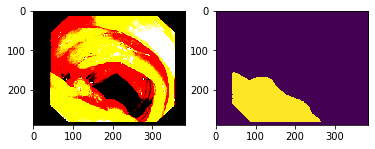

y_pred


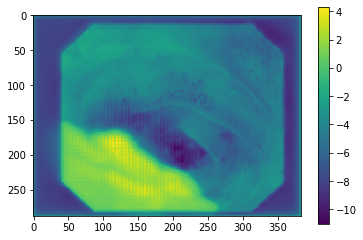

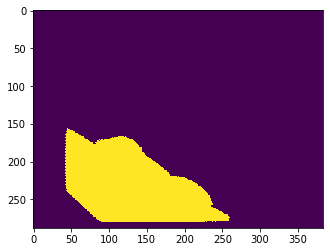

In [18]:
dataloader = DataLoader(colon_dataset, batch_size=1, shuffle=False)


# Grab the first batch
first_batch = None
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 0:
        first_batch = sample_batched
        break

batch_shape = first_batch[0].shape
# Changing dimension
X = change_input_dimension(first_batch[0]).to(dtype=torch.float)
#X = sample_batched[0].view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2]).to(dtype=torch.float)
y = first_batch[1].to(dtype=torch.int64)
#X = X.to(device)
#y = y.to(device)

y_pred =  model(X)
y_pred = y_pred.cpu()
y_pred = y_pred.detach().numpy()
print(y_pred.shape)

y_pred = y_pred[0][1]
#plt.imshow(y_pred)
#plt.colorbar()
#plt.show()
#print(np.abs(y_pred - y.detach().numpy()))    
y_pred = torch.Tensor([y_pred])
#print(y_pred[0][0])
#print(y_pred[0].shape)
print(y_pred.shape)
print(y.shape)
i = iou(y_pred, y)
print("IoU Value:", i)

print("Original Image and Mask:")
show_colon_batch(first_batch)

y_pred = y_pred.permute([1,2,0])
#print(y_pred.shape)

print("y_pred")
plt.imshow(y_pred[:,:,0])
plt.colorbar()
plt.show()

plt.imshow(y_pred[:,:,0] > 0)
#plt.colorbar()
plt.show()

In [31]:
iou_metric_list = []

temp_iou_list = np.array([])
for i_batch, sample_batched in enumerate(dataloader):
    batch_shape = sample_batched[0].shape
    X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
    y = sample_batched[1].to(dtype=torch.int64)
    #X = X.to(device); y = y.to(device)
    prediction = model(X)
    #prediction = prediction.cpu(); X = X.cpu(); y = y.cpu()
    temp = iou(prediction[:, 1], y)
    temp_iou_list = np.concatenate((temp_iou_list, temp))
    print(temp)
    
iou_metric_list.append(np.mean(temp_iou_list))

(288, 384, 3)
[16300] [33323]
[0.95752805]
(288, 384, 3)
[14559] [32825]
[0.79705464]
(288, 384, 3)
[6667] [14694]
[0.83057182]
(288, 384, 3)
[7384] [15445]
[0.91601538]
(288, 384, 3)
[7273] [15202]
[0.91726573]
(288, 384, 3)
[9076] [19303]
[0.88745478]
(288, 384, 3)
[12791] [26913]
[0.90574989]
(288, 384, 3)
[15125] [31570]
[0.91973244]
(288, 384, 3)
[11146] [25628]
[0.76964508]
(288, 384, 3)
[19957] [41063]
[0.9455605]
(288, 384, 3)
[18694] [38548]
[0.94157349]
(288, 384, 3)
[17364] [35643]
[0.94994256]
(288, 384, 3)
[13811] [31540]
[0.77900615]
(288, 384, 3)
[24176] [49621]
[0.95012773]
(288, 384, 3)
[24217] [49872]
[0.94394855]
(288, 384, 3)
[24700] [50550]
[0.95551257]
(288, 384, 3)
[24666] [50752]
[0.94556467]
(288, 384, 3)
[24706] [51926]
[0.90764144]
(288, 384, 3)
[14029] [29530]
[0.90503838]
(288, 384, 3)
[14634] [30595]
[0.91685985]
(288, 384, 3)
[12414] [26409]
[0.88703108]
(288, 384, 3)
[13976] [29807]
[0.88282484]
(288, 384, 3)
[12040] [25558]
[0.8906643]
(288, 384, 3)
[23

[20326] [46402]
[0.77949072]
(288, 384, 3)
[19426] [41514]
[0.87948207]
(288, 384, 3)
[13845] [29463]
[0.88647714]
(288, 384, 3)
[2052] [4450]
[0.85571309]
(288, 384, 3)
[2496] [5288]
[0.89398281]
(288, 384, 3)
[3478] [7318]
[0.90572917]
(288, 384, 3)
[2907] [6148]
[0.89694539]
(288, 384, 3)
[3199] [6853]
[0.87547893]
(288, 384, 3)
[3774] [7936]
[0.90677559]
(288, 384, 3)
[3588] [7694]
[0.87384316]
(288, 384, 3)
[2651] [5919]
[0.81119951]
(288, 384, 3)
[2880] [6580]
[0.77837838]
(288, 384, 3)
[3500] [7786]
[0.81661223]
(288, 384, 3)
[2858] [6438]
[0.79832402]
(288, 384, 3)
[3233] [7020]
[0.85371006]
(288, 384, 3)
[1669] [4912]
[0.51464693]
(288, 384, 3)
[3826] [8335]
[0.84852517]
(288, 384, 3)
[1591] [3479]
[0.84269068]
(288, 384, 3)
[1528] [3316]
[0.85458613]
(288, 384, 3)
[2219] [5423]
[0.69257179]
(288, 384, 3)
[3178] [6886]
[0.8570658]
(288, 384, 3)
[3268] [7061]
[0.86158713]
(288, 384, 3)
[3118] [6707]
[0.86876567]
(288, 384, 3)
[2423] [5179]
[0.87917271]
(288, 384, 3)
[2261] [509

[3535] [7417]
[0.91061309]
(288, 384, 3)
[3875] [8059]
[0.92614723]
(288, 384, 3)
[6265] [13143]
[0.91087525]
(288, 384, 3)
[8359] [18790]
[0.80136133]
(288, 384, 3)
[10613] [22011]
[0.93112827]
(288, 384, 3)
[8489] [19086]
[0.80107578]
(288, 384, 3)
[4441] [9474]
[0.88237632]
(288, 384, 3)
[4147] [8986]
[0.85699525]
(288, 384, 3)
[5205] [11544]
[0.82110743]
(288, 384, 3)
[5083] [10525]
[0.93403161]
(288, 384, 3)
[6286] [13150]
[0.91579254]
(288, 384, 3)
[7241] [14911]
[0.9440678]
(288, 384, 3)
[10721] [22518]
[0.90879037]
(288, 384, 3)
[8199] [17017]
[0.92980268]
(288, 384, 3)
[11106] [23397]
[0.90358799]
(288, 384, 3)
[10844] [23093]
[0.88529676]
(288, 384, 3)
[3348] [13239]
[0.33848954]
(288, 384, 3)
[8583] [20502]
[0.72011075]
(288, 384, 3)
[10646] [24031]
[0.79536795]
(288, 384, 3)
[9436] [19876]
[0.90383142]
(288, 384, 3)
[5019] [15017]
[0.5020004]
(288, 384, 3)
[16232] [38325]
[0.73471235]
(288, 384, 3)
[10265] [33353]
[0.44460326]
(288, 384, 3)
[12831] [29782]
[0.75694649]
(288

[1473] [3561]
[0.70545977]
(288, 384, 3)
[24276] [49278]
[0.97096232]
(288, 384, 3)
[1063] [2496]
[0.74180042]
(288, 384, 3)
[6496] [14390]
[0.82290347]
(288, 384, 3)
[3407] [7097]
[0.92330623]
(288, 384, 3)
[7483] [15652]
[0.91602399]
(288, 384, 3)
[4891] [10257]
[0.91147969]
(288, 384, 3)
[5665] [11940]
[0.90278884]
(288, 384, 3)
[5300] [11425]
[0.86530612]
(288, 384, 3)
[5920] [12395]
[0.91428571]
(288, 384, 3)
[4324] [8943]
[0.93613336]
(288, 384, 3)
[4563] [9434]
[0.93676863]
(288, 384, 3)
[13782] [28256]
[0.95219013]
(288, 384, 3)
[4803] [9975]
[0.92865429]
(288, 384, 3)
[4623] [9633]
[0.92275449]
(288, 384, 3)
[3681] [7718]
[0.9118157]
(288, 384, 3)
[3704] [7675]
[0.93276253]
(288, 384, 3)
[4062] [8590]
[0.89708481]
(288, 384, 3)
[4132] [8760]
[0.89282627]
(288, 384, 3)
[4124] [8862]
[0.87040946]
(288, 384, 3)
[3193] [6833]
[0.8771978]
(288, 384, 3)
[8887] [18875]
[0.88976772]
(288, 384, 3)
[6684] [14894]
[0.81412911]


In [46]:
np.save( "iou_metric_list_25epochs.npy", temp_iou_list)

In [14]:
temp_iou_list = np.load("iou_metric_list_25epochs_95decay.npy")
iou_metric_list = []
iou_metric_list.append(np.mean(temp_iou_list))
print(iou_metric_list)
#print(temp_iou_list)

[0.8228297623382534]


In [44]:
#print(len(temp_iou_list))
#print(temp_iou_list)
#print(temp_iou_list < 0.7)
#print(temp_iou_list[ temp_iou_list < 0.7])
#print(np.where(temp_iou_list < 0.1))

In [19]:
# Using Test Data
#root_dir = "./test-data/ETIS-LaribPolypDB"
#input_dir = root_dir + "/ETIS-LaribPolypDB/"
#target_dir = root_dir + "/mask/"

root_dir = "./siwei_images_3"
input_dir = root_dir + "/nonboxed/"
target_dir = root_dir + "/final/"

#test_dataset = ColonTifDataset(input_dir, target_dir)
test_dataset = ColonImageDataset(input_dir, target_dir)

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

iou_metric_list = []

temp_iou_list = np.array([])
for i_batch, sample_batched in enumerate(dataloader):
    batch_shape = sample_batched[0].shape
    X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
    y = sample_batched[1].to(dtype=torch.int64)
    #X = X.to(device); y = y.to(device)
    prediction = model(X)
    #prediction = prediction.cpu(); X = X.cpu(); y = y.cpu()
    print("Target Shape:", y.shape)
    print("Prediction Shape:", prediction.shape)
    temp = iou(prediction[:, 1], y)
    temp_iou_list = np.concatenate((temp_iou_list, temp))
    print(temp)
    
iou_metric_list.append(np.mean(temp_iou_list))


119.41733963218111 26.283084104364733
(966, 1225, 3)


KeyboardInterrupt: 

66.57122014973962 13.927918705000424
(480, 640, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 2, 480, 640)
y_pred shape: torch.Size([1, 480, 640])
y shape: torch.Size([1, 480, 640])
Original Image and Mask:


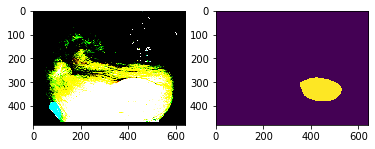

y


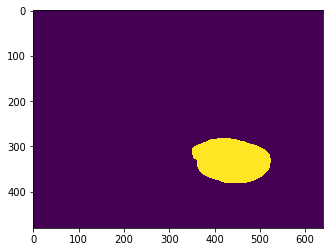

y_pred


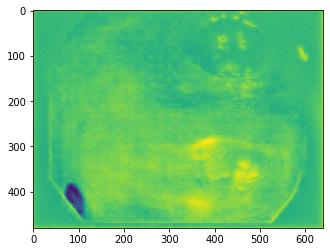

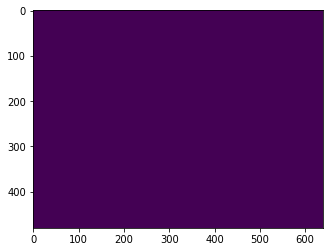

In [19]:
#dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
root_dir = "./siwei_images_3"
input_dir = root_dir + "/nonboxed/"
target_dir = root_dir + "/final/"

#test_dataset = ColonTifDataset(input_dir, target_dir)
test_dataset = ColonImageDataset(input_dir, target_dir)

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Grab the first batch
first_batch = None
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 0:
        first_batch = sample_batched
        break

batch_shape = first_batch[0].shape
# Changing dimension
X = change_input_dimension(first_batch[0]).to(dtype=torch.float)
#X = sample_batched[0].view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2]).to(dtype=torch.float)
y = first_batch[1].to(dtype=torch.int64)
#X = X.to(device)
#y = y.to(device)

y_pred =  model(X)
y_pred = y_pred.cpu()
y_pred = y_pred.detach().numpy()
print(y_pred.shape)

y_pred = y_pred[0][1]
#plt.imshow(y_pred)
#plt.colorbar()
#plt.show()
#print(np.abs(y_pred - y.detach().numpy()))    
y_pred = torch.Tensor([y_pred])
#print(y_pred[0][0])
#print(y_pred[0].shape)
print("y_pred shape:", y_pred.shape)
print("y shape:", y.shape)
#i = iou(y_pred, y)
#print("IoU Value:", i)

print("Original Image and Mask:")
show_colon_batch(first_batch)

y_pred = y_pred.permute([1,2,0])
#print(y_pred.shape)

print("y")
plt.imshow(y.permute([1,2,0]).numpy()[:,:,0])
plt.show()

print("y_pred")
plt.imshow(y_pred[:,:,0])
#plt.colorbar()
plt.show()

#print(y_pred.numpy().dtype)
#arrMax = np.amax(y_pred.numpy())
#print(arrMax)
#thresh = arrMax - (arrMax * -0.999999999)
thresh = 0

plt.imshow(y_pred[:,:,0] > thresh)
#plt.colorbar()
plt.show()

# Additional Training After

In [22]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#print("Before:", torch.cuda.memory_allocated(device))

model = UNet(in_channels=3, n_classes=2, padding=True, up_mode='upconv')
model.load_state_dict( torch.load("colon-unet-public-dataset-25epochs-95decay.pt") )
model.to(device)

#print("After:", torch.cuda.memory_allocated(device))

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

expon_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)

torch.cuda.empty_cache()
#print("After empty:", torch.cuda.memory_allocated(device))

In [23]:
root_dir = "./siwei_images_3"
input_dir = root_dir + "/nonboxed/"
target_dir = root_dir + "/final/"

test_dataset = ColonImageDataset(input_dir, target_dir)

dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

66.57122014973962 13.927918705000424


In [24]:
loss_l = []
epochs = 25
print("Epochs: ", epochs)
for _ in range(epochs):
    #X, y = dataloader
    print("Epoch #: ", _)
    for i_batch, sample_batched in enumerate(dataloader):
        batch_shape = sample_batched[0].shape
        # Changing dimension
        X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
        #X = sample_batched[0].view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2]).to(dtype=torch.float)
        y = sample_batched[1].to(dtype=torch.int64)
        X = X.to(device)
        y = y.to(device)
        
        prediction =  model(X)
        loss = F.cross_entropy(prediction, y)
        
        X = X.cpu()
        y = y.cpu()
        
        if i_batch == 299 or len(loss_l) == 0:
            loss_l.append(loss.item())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    expon_scheduler.step()

Epochs:  25
Epoch #:  0
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640,

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
Epoch #:  3
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 64

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
Epoch #:  6
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 64

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
Epoch #:  9
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 64

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
Epoch #:  12
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 6

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 

In [25]:
# EPOCH
torch.save(model.state_dict(), "colon-unet-public-dataset-25epochs-extra-siwei-images3.pt")

66.57122014973962 13.927918705000424
(480, 640, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 2, 480, 640)
y_pred shape: torch.Size([1, 480, 640])
y shape: torch.Size([1, 480, 640])
[12788] [26281]
IoU Value: [0.94775069]
Original Image and Mask:


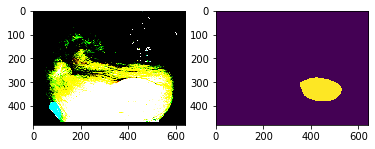

y


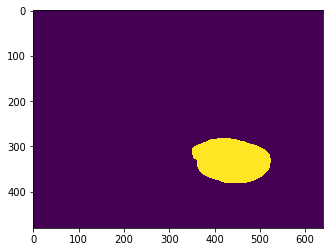

y_pred


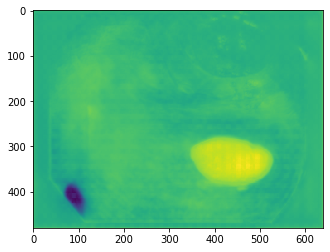

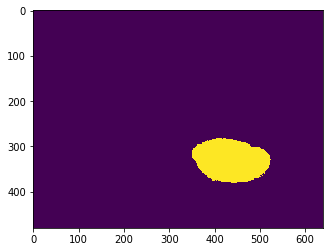

In [29]:
root_dir = "./siwei_images_3"
input_dir = root_dir + "/nonboxed/"
target_dir = root_dir + "/final/"

#test_dataset = ColonTifDataset(input_dir, target_dir)
test_dataset = ColonImageDataset(input_dir, target_dir)

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Grab the first batch
first_batch = None
for i_batch, sample_batched in enumerate(dataloader):
    if i_batch == 0:
        first_batch = sample_batched
        break

batch_shape = first_batch[0].shape
# Changing dimension
X = change_input_dimension(first_batch[0]).to(dtype=torch.float)
#X = sample_batched[0].view(batch_shape[0], batch_shape[3], batch_shape[1], batch_shape[2]).to(dtype=torch.float)
y = first_batch[1].to(dtype=torch.int64)
#X = X.to(device)
#y = y.to(device)

y_pred =  model(X)
y_pred = y_pred.cpu()
y_pred = y_pred.detach().numpy()
print(y_pred.shape)

y_pred = y_pred[0][1]
#plt.imshow(y_pred)
#plt.colorbar()
#plt.show()
#print(np.abs(y_pred - y.detach().numpy()))    
y_pred = torch.Tensor([y_pred])
#print(y_pred[0][0])
#print(y_pred[0].shape)
print("y_pred shape:", y_pred.shape)
print("y shape:", y.shape)
i = iou(y_pred, y)
print("IoU Value:", i)

print("Original Image and Mask:")
show_colon_batch(first_batch)

y_pred = y_pred.permute([1,2,0])
#print(y_pred.shape)

print("y")
plt.imshow(y.permute([1,2,0]).numpy()[:,:,0])
plt.show()

print("y_pred")
plt.imshow(y_pred[:,:,0])
#plt.colorbar()
plt.show()

#print(y_pred.numpy().dtype)
#arrMax = np.amax(y_pred.numpy())
#print(arrMax)
#thresh = arrMax - (arrMax * -0.999999999)
thresh = 0

plt.imshow(y_pred[:,:,0] > thresh)
#plt.colorbar()
plt.show()

### Reload Weights into Model and IoU Test

In [25]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

model = UNet(in_channels=3, n_classes=2, padding=True, up_mode='upconv')
model.load_state_dict( torch.load("colon-unet-public-dataset-25epochs-extra-siwei-images3.pt") )
#model.to(device)

#print("After:", torch.cuda.memory_allocated(device))

optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

expon_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95)


In [26]:
root_dir = "./siwei_images_3"
input_dir = root_dir + "/nonboxed/"
target_dir = root_dir + "/final/"

#test_dataset = ColonTifDataset(input_dir, target_dir)
test_dataset = ColonImageDataset(input_dir, target_dir)

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

iou_metric_list = []

temp_iou_list = np.array([])
for i_batch, sample_batched in enumerate(dataloader):
    batch_shape = sample_batched[0].shape
    X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
    y = sample_batched[1].to(dtype=torch.int64)
    #X = X.to(device); y = y.to(device)
    prediction = model(X)
    #prediction = prediction.cpu(); X = X.cpu(); y = y.cpu()
    print("Target Shape:", y.shape)
    print("Prediction Shape:", prediction.shape)
    temp = iou(prediction[:, 1], y)
    temp_iou_list = np.concatenate((temp_iou_list, temp))
    print(temp)
    
iou_metric_list.append(np.mean(temp_iou_list))


66.57122014973962 13.927918705000424
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[12788] [26281]
[0.94775069]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[15252] [31209]
[0.95581876]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[1854] [4043]
[0.84696208]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[6518] [13526]
[0.93007991]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[4898] [10170]
[0.92905918]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[1882] [3949]
[0.91049831]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[4931] [10355]
[0.90910767]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Predic

Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[16932] [34631]
[0.95666422]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[30382] [61962]
[0.9620646]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[18624] [37992]
[0.96158612]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[41169] [84206]
[0.95659549]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[6075] [12797]
[0.90374888]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[34572] [70535]
[0.96132136]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[3927] [8393]
[0.87931034]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[41415]

Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[11149] [23568]
[0.89773734]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[9615] [20182]
[0.9099082]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[7208] [15266]
[0.89451477]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[6059] [12784]
[0.90096654]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[5144] [10840]
[0.90308989]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[3833] [8279]
[0.86212326]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[1391] [3032]
[0.84765387]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[2216] [4841

Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[6564] [13731]
[0.91586438]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[18541] [38443]
[0.93161491]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[5061] [10638]
[0.90747714]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[26192] [54111]
[0.93814248]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[70780] [144211]
[0.96389808]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[23317] [48652]
[0.92034735]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[5182] [10971]
[0.89514597]
(480, 640, 3)
Target Shape: torch.Size([1, 480, 640])
Prediction Shape: torch.Size([1, 2, 480, 640])
[2865

In [27]:
print(iou_metric_list)

[0.9183972018344454]


In [28]:
root_dir = "./train-data/CVC-ClinicDB"
input_dir = root_dir + "/Original/"
target_dir = root_dir + "/mask/"

colon_dataset = ColonTifDataset(input_dir, target_dir)

dataloader = DataLoader(colon_dataset, batch_size=1, shuffle=False)

#iou_metric_list = []

temp_iou_list = np.array([])
for i_batch, sample_batched in enumerate(dataloader):
    batch_shape = sample_batched[0].shape
    X = change_input_dimension(sample_batched[0]).to(dtype=torch.float)
    y = sample_batched[1].to(dtype=torch.int64)
    #X = X.to(device); y = y.to(device)
    prediction = model(X)
    #prediction = prediction.cpu(); X = X.cpu(); y = y.cpu()
    print("Target Shape:", y.shape)
    print("Prediction Shape:", prediction.shape)
    temp = iou(prediction[:, 1], y)
    temp_iou_list = np.concatenate((temp_iou_list, temp))
    print(temp)
    
iou_metric_list.append(np.mean(temp_iou_list))

72.61936890229575 12.617953816028486
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [16978]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [18262]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[248] [7463]
[0.03437283]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[6311] [14181]
[0.80190597]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[6090] [13933]
[0.77648859]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[7144] [16622]
[0.75374552]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [13263]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [7893]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [8226]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3163]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[1648] [7027]
[0.30637665]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [5162]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3975]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[39] [14237]
[0.00274687]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[1406] [8739]
[0.19173599]
(288, 384, 3)
Target Shape: torch.Size([1, 288

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [4055]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3450]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[239] [3587]
[0.0713859]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [2921]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3343]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [5227]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3005]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [8445]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shap

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [4068]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3089]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3393]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3726]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3507]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3708]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3243]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[957] [5389]
[0.2159296]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shap

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [7360]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [13632]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [12714]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [3863]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [5019]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [23020]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[240] [23958]
[0.0101189]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[3533] [10744]
[0.48994592]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [10879]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [9051]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [9657]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [10814]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [7963]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[1234] [29921]
[0.043016]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[175] [4946]
[0.03667994]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[231] [9114]
[0.02600473]
(288, 384, 3)
Target Shape: torch.Size([1, 288

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[4245] [12757]
[0.49870771]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[5005] [17058]
[0.41524932]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[3335] [14682]
[0.29391028]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [9826]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [11824]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [13356]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[637] [11034]
[0.06126767]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [9954]
[0.]
(288, 384, 3)
Target Shape: t

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [4861]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[239] [20003]
[0.01209269]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[2127] [13059]
[0.19456641]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[2257] [10824]
[0.26345278]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[5519] [14002]
[0.65059531]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[5350] [15973]
[0.50362421]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[838] [3448]
[0.3210728]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [819]
[0.]
(288, 384, 

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [2417]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [4440]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [2559]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [2184]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [2450]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [1155]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [2147]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [1963]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.

Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[1759] [6196]
[0.39643904]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [4552]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[0] [4236]
[0.]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[91] [3471]
[0.02692308]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[3960] [13880]
[0.39919355]
(288, 384, 3)
Target Shape: torch.Size([1, 288, 384])
Prediction Shape: torch.Size([1, 2, 288, 384])
[2400] [9704]
[0.32858708]


In [29]:
print(iou_metric_list)

[0.9183972018344454, 0.17294973266439853]
